# Binning analysis (truncated)

In [44]:
# Statistical analysis library for Monte Carlo Data
import math as m
import numpy as np
import os.path
import sys
import matplotlib.pyplot as plt

In [45]:
#!/usr/bin/python
# pimcstat.py
# Chris Herdman
# 11.30.2012
# 


# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin bin function
# -----------------------------------------------------------------------------
# Returns error as a funciton of bin level (D)
# Requires raw Monte Carlo bin data in horizontal rows
# -----------------------------------------------------------------------------
def bindata(MC):
    
    # minimum number of MC bins required
    min_bin = 32

    # initialize B to MC data
    B = MC

    # Resize if 1D array
    if B.ndim == 1:
        B.resize(B.shape[0],1)

    try:
        # Define number of binning levels
        Nl = int(m.floor(m.log(B.shape[0]/min_bin,2))+1)

    except:
        print("Not enough bins. Need {} bins and have {} bins. Setting binning level to 1.".format(min_bin,B.shape[0]))
        Nl = 1

    # initialize D
    D = np.zeros((Nl,B.shape[1]))
    
    # First level of binning is raw data
    D[0,:] = np.std(MC,0)/m.sqrt(B.shape[0]-1)
    
    # Binning loop over levels l
    for l in range(1,Nl):
        
        # Bin pairs of bins: if odd # of bins, truncate first bin
        if ((B.shape[0] % 2) == 0):
            B = (B[::2,:]+ B[1::2,:])/2
        else:
            B = (B[1::2,:]+ B[2::2,:])/2
        
        # Error at level l
        D[l,:] = np.std(B,0)/m.sqrt(B.shape[0]-1)
    
    return D
# -----------------------------------------------------------------------------
# end of bin function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin autocorr function
# -----------------------------------------------------------------------------
# Returns autocorrelation as a funciton of MC update time
# Averages dt over entire MC run, from dt=1 to dt=T/2
# -----------------------------------------------------------------------------
def autocorr(MC):
    
    # Reshape MC to 2D array if column vector
    if MC.ndim == 1:
        MC.resize(MC.shape[0],1)
    
    # Number of MC bins
    T = MC.shape[0]
    
    # Number of AC steps
    Nt = T//2+1
    
    ac = np.zeros((Nt,MC.shape[1]))
    dac = np.zeros((Nt,MC.shape[1]))
    
    A2 = np.average(MC,0)**2
    dA2 = np.sqrt(2*A2)*np.std(MC,0)/np.sqrt(T)
    AA = np.average(MC*MC,0)
    dAA = np.std(MC*MC,0)/np.sqrt(T)
    ac[0,:] = np.ones((1,MC.shape[1]))
    for dt in range(1,Nt):
        AtA0 = MC[:-dt,:]*MC[dt:,:]
        ac[dt,:] = (np.average(AtA0,0)-A2)/(AA-A2)
        dac[dt,:] = np.sqrt( (ac[dt,:]**2)*( \
                    (np.std(AtA0,0)**2/AtA0.shape[0]+dA2**2)/ \
                    (np.average(AtA0,0)-A2)**2 + (dAA**2+dA2**2)/(AA-A2)**2) )
    
    return {'correlation':ac, 'error':dac}
# -----------------------------------------------------------------------------
# end of autocorr function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Begin bin_ac function
# -----------------------------------------------------------------------------
# Returns estimate of autocorrelation time in bins from binning analysis (tau)
# Requires processed bins from bin function
# -----------------------------------------------------------------------------
def bin_ac(D,dD=None):
    
    if D.ndim == 1:
        D.resize((len(D),1))
        if dD is not None:
            dD.resize((len(dD),1))
        
    # initialize autocorrelation time
    tau = np.zeros(D.shape[1])
    dtau = np.zeros(D.shape[1])
    
    #Loop of columns of D to compute tau,CF
    for c in range(D.shape[1]):
        if D[0,c] != 0.0:
            tau[c] = 0.5*((D[-1,c]/D[0,c])**2-1)
            if dD is not None:
                dtau[c] = np.sqrt(tau[c]**2*( (dD[-1,c]/D[-1,c])**2 + \
                                   (dD[0,c]/D[0,c])**2 ) )
            
    return {'tau':tau,'dtau':dtau}
# -----------------------------------------------------------------------------
# end of bin_ac function
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

def moving_average(data) :
    return np.divide(np.cumsum(data),np.arange(1,data.shape[0]+1,1))

In [46]:
# Load data
K_SF = np.loadtxt("1D_4_4_2_3.300000_1.000000_4.000000_100_K_1968_square.dat")
V_SF = np.loadtxt("1D_4_4_2_3.300000_1.000000_4.000000_100_V_1968_square.dat")

In [47]:
# Perform running averages
K_SF_runningAve = moving_average(K_SF)
V_SF_runningAve = moving_average(V_SF)

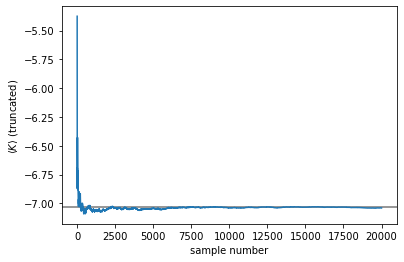

In [48]:
# Plot running average
plt.plot(K_SF_runningAve)
plt.ylabel(r'$\langle K \rangle$ (truncated)')
plt.xlabel('sample number')
plt.axhline(-7.032152613680843,zorder=-1,color='#777777')
plt.savefig("runningAve_K_truncated.pdf",dpi=300)

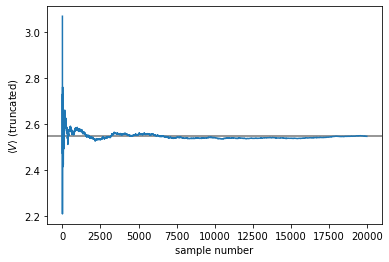

In [49]:
# Plot running average
plt.plot(V_SF_runningAve)
plt.ylabel(r'$\langle V \rangle$ (truncated)')
plt.xlabel('sample number')
plt.axhline(2.548976013564859,zorder=-1,color='#777777')
plt.savefig("runningAve_V_truncated.pdf",dpi=300)

In [50]:
# Throw away unequilibrated data
K_SF = K_SF[3000:]
V_SF = V_SF[3000:]

In [51]:
# Compute error as a function of bin levelb
binned_K_SF = bindata(K_SF)
binned_V_SF = bindata(V_SF)

Text(0.5, 0, 'bin level')

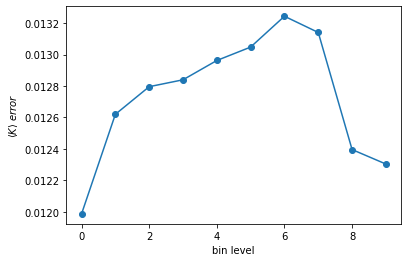

In [52]:
# Plot binned error
plt.plot(binned_K_SF,'-o')
plt.ylabel(r'$\langle K \rangle \; error$')
plt.xlabel('bin level')

Text(0.5, 0, 'bin level')

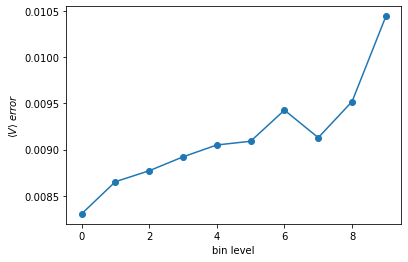

In [53]:
# Plot binned error
plt.plot(binned_V_SF,'-o')
plt.ylabel(r'$\langle V \rangle \; error$')
plt.xlabel('bin level')

In [54]:
# Print out results
print("<K> = %.4f +/- %.4f"%(np.mean(K_SF),binned_K_SF.max()))
print("<V> = %.4f +/- %.4f"%(np.mean(V_SF),binned_V_SF.max()))

<K> = -7.0378 +/- 0.0132
<V> = 2.5482 +/- 0.0104


In [55]:
K_exact = -7.032152613680843
V_exact = 2.548976013564859

In [56]:
print("Estimator  Exact     Monte Carlo                     (N=4)")

print(f"<K>       {K_exact:0.4f}   {np.mean(K_SF):0.4f} +/- {binned_K_SF.max():0.4f}  {np.abs(np.mean(K_SF)-K_exact)/binned_K_SF.max():0.4f}σ")
print(f"<V>        {V_exact:0.4f}    {np.mean(V_SF):0.4f} +/- {binned_V_SF.max():0.4f}  {np.abs(np.mean(V_SF)-V_exact)/binned_V_SF.max():0.4f}σ")

Estimator  Exact     Monte Carlo                     (N=4)
<K>       -7.0322   -7.0378 +/- 0.0132  0.4254σ
<V>        2.5490    2.5482 +/- 0.0104  0.0710σ


In [57]:
0.5*((max(binned_K_SF)/binned_K_SF[0])**2 - 1)

array([0.11025504])

In [58]:
# Estimate autocorrelation times from binned data
bin_ac(binned_K_SF),bin_ac(binned_V_SF)

({'tau': array([0.02677992]), 'dtau': array([0.])},
 {'tau': array([0.29043907]), 'dtau': array([0.])})

In [59]:
# Compute autocorrelation times from MC data
autocorr_K_SF = autocorr(K_SF)
autocorr_V_SF = autocorr(V_SF)

In [60]:
autocorr_K_SF['correlation'][:10]

array([[ 1.        ],
       [ 0.09937828],
       [-0.00814655],
       [-0.0048262 ],
       [ 0.00590312],
       [-0.00587482],
       [-0.00591215],
       [-0.00826217],
       [-0.00178288],
       [-0.01102724]])

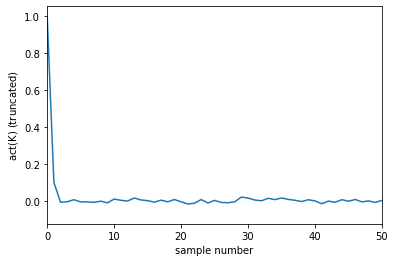

In [76]:
# Plot act for kinetic energy
plt.plot(range(len(autocorr_K_SF['correlation'])),autocorr_K_SF['correlation'])
plt.ylabel(r'$\rm{act}(K)$ (truncated)')
plt.xlabel(r'sample number')
plt.yscale('linear')
plt.xlim(0,50)
# plt.ylim(1e-8,1)
plt.savefig("act_kinetic_truncated.pdf",dpi=300)

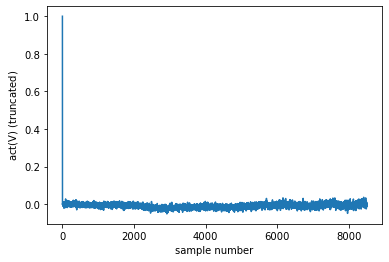

In [62]:
# Plot act for potential energy
plt.plot(range(len(autocorr_V_SF['correlation'])),autocorr_V_SF['correlation'])
plt.ylabel(r'$\rm{act}(V)$ (truncated)')
plt.xlabel(r'sample number')
plt.yscale('linear')
plt.savefig("act_potential_truncated.pdf",dpi=300)

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

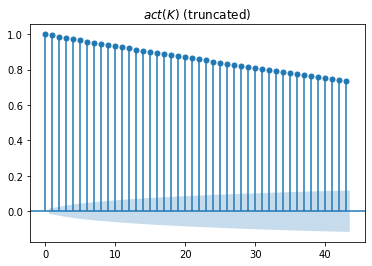

In [15]:
plot_acf(K_SF,title=r'$act(K)$ (truncated)')
plt.savefig("act_potential_truncated.pdf",dpi=300)
plt.show()

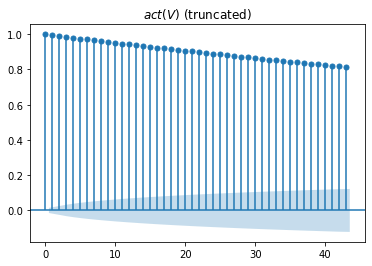

In [16]:
plot_acf(V_SF,title=r'$act(V)$ (truncated)')
plt.savefig("act_potential_truncated.pdf",dpi=300)
plt.show()